In [1]:
from sympy import diff, lambdify, symbols, sqrt, cos
import numpy as np
import rebound
from scipy.integrate import odeint
from sympy import init_printing
init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import FloatSlider

In [2]:
gamma, eta, Lambda, I, psi, phi = symbols("gamma, eta, Lambda, I, psi, phi")
H = Lambda**2/2 + gamma*I - cos(psi) - eta*cos(psi - phi)

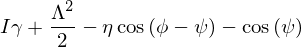

In [3]:
H

This is what I get for the Hamiltonian 5 if we drop the $I^2$ term, nondimensionalize the actions by the width of the $\cos{\psi}$ resonance, $\Delta\Lambda = \left(\frac{\mu D}{A}\right)^{1/2}$ and the time through $t' = \omega t$, with $\omega$ the frequency of small oscillations in the $\cos(\psi)$ resonance, $\omega = \left(\mu D A \right)^{1/2}$.  This cuts the number of parameters in half and should make it easier to see what's going on.  The new parameters are related to the ones in Murray & Holman (1997) as $\gamma = \left( \frac{\mu B^2}{D A} \right)^{1/2} \approx K^{-1/2}$, where K is the stochasticity parameter and $\eta = \frac{E}{D} \approx 1$.

# Calculate Hamilton's equations symbolically

In [4]:
var = (psi, phi, Lambda, I, gamma, eta)

In [5]:
Lambdadot = lambdify(var, -diff(H, psi), 'numpy')
Idot = lambdify(var, -diff(H, phi), 'numpy')
psidot = lambdify(var, diff(H, Lambda), 'numpy')
phidot = lambdify(var, diff(H, I), 'numpy')

In [6]:
def diffeq(y, t, *params):
    psi, phi, Lambda, I = y
    v = np.concatenate((y, params))
    dydt = [psidot(*v), phidot(*v), Lambdadot(*v), Idot(*v)]
    return dydt

# A simple integration

The integrate function takes a tuple with the initial conditions (in the order psi, phi, Lambda, I) and the parameters (gamma, eta) and plots psi vs Lambda.

In [7]:
def wrap(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return val

npwrap = np.vectorize(wrap)

def integrate(y0, params):
    times = np.linspace(0, 100, 1000)
    sol = odeint(diffeq, y0, times, args=params)
    solpsi = npwrap(sol[:,0])
    solphi = npwrap(sol[:,1])
    solLambda = sol[:,2]
    solI = sol[:,3]
    
    fig, ax = plt.subplots(figsize=(15,10))
    #ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
    ax.set_xlabel(r"$\psi$", fontsize=24)
    ax.set_ylabel(r"$\Lambda$", fontsize=24)
    
    
    ax.plot(solpsi, solLambda, '.')
    ax.set_aspect('equal')
    
    fig.show()

/Users/dtamayo/miniconda2/envs/p3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


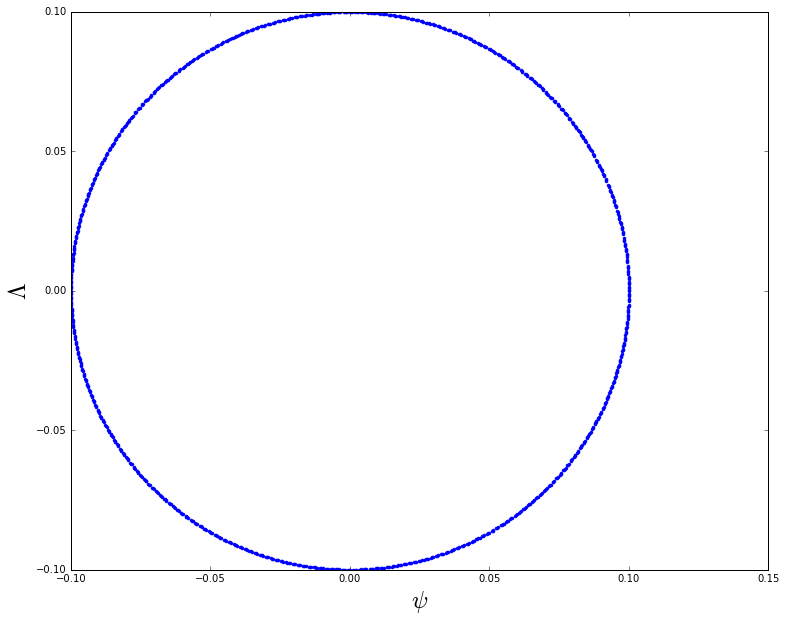

In [29]:
gamma = 2.
eta = 0.
psi0 = 0.1
phi0 = 0.
Lambda0 = 0.
I0 = 0.

y0 = (psi0, phi0, Lambda0, I0)
params = (gamma, eta)
integrate(y0, params)

# Make Surface of Section

In [76]:
def sign(y):
    return mod2pi(y[1])

def mod2pi(x):
    if x>np.pi:
        return mod2pi(x-2.*np.pi)
    if x<-np.pi:
        return mod2pi(x+2.*np.pi)
    return x

In [85]:
N_points_max = 2000  # maximum number of point in our Poincare Section
tmax=100
def trajectory(y0, params):          
    N_points = 0
    crossings = np.zeros((N_points_max, 4))
    
    dt = 0.1
    dt_epsilon = 0.001
    
    t=0
    y=y0
    s = sign(y)
    while t < tmax and N_points < N_points_max:
        oldt = t      
        y = odeint(diffeq, y, [oldt, oldt+dt], args=params)[1] # take the second state at oldt+dt
        t = oldt+dt
        snew = sign(y)
        if s < 0. and snew > 0.: # section crossed
            leftt = oldt
            rightt = t
            while (rightt - leftt > dt_epsilon):
                midt = (leftt+rightt)/2.
                y = odeint(diffeq, y, [t, midt], args=params)[1] # take the second state at t+dt
                t = midt
                smid = sign(y)
                if smid*s > 0.: # crossing happened after midt
                    leftt = midt
                else:
                    rightt = midt
            # Crossing found to within dt_epsilon
            crossings[N_points] = [mod2pi(y[0]), mod2pi(y[1]), y[2], y[3]]
            N_points += 1
            y = odeint(diffeq, y, [t, t+dt], args=params)[1] # move past crossing
            t = t+dt
        s = snew
    
    return crossings

# Surface of Section

Set the gamma and eta parameters (same as in Hamiltonian above).  Set initial value I0.  Choose how to populate the surface by sampling values of Lambda (that's what the for loops below do)

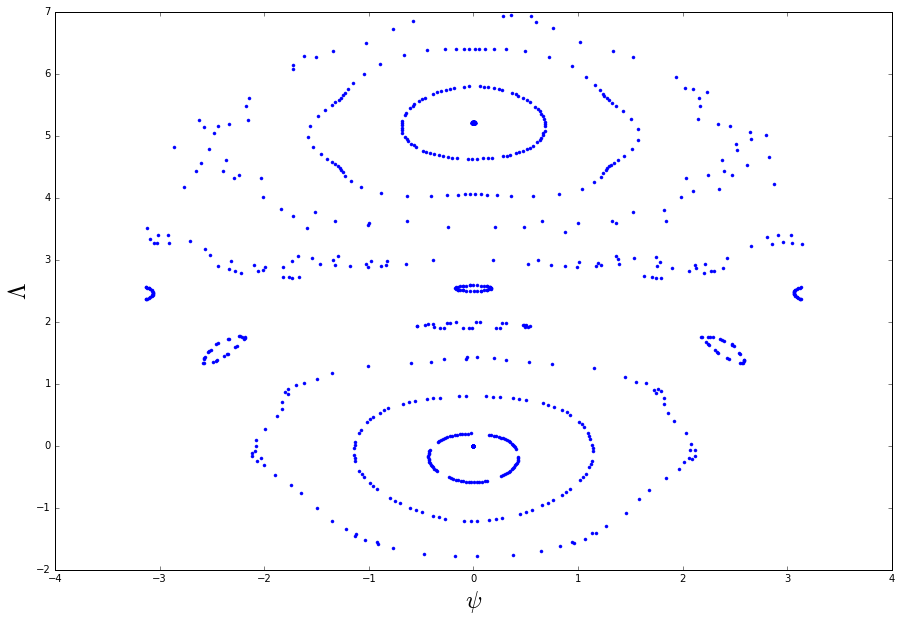

In [96]:
gamma = 5.
eta = 0.9
params = (gamma, eta)

psi0 = 0
phi0 = 0
Lambda0 = 1
I0 = 0.01

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))
for L in np.linspace(0.2, 2, 4, endpoint=True):
    y0 = (psi0, phi0, L, I0) # populate section with trajectories with different Lambda
    crossings = trajectory(y0, params)
    ax.plot(crossings[:,0], crossings[:,2], '.b') # 0=psi, 1=phi, 2=Lambda, 3=I
    
for L in np.linspace(gamma+0.2, gamma+2, 4, endpoint=True):
    y0 = (psi0, phi0, L, I0) # populate section with trajectories with different Lambda
    crossings = trajectory(y0, params)
    ax.plot(crossings[:,0], crossings[:,2], '.b') # 0=psi, 1=phi, 2=Lambda, 3=I
    
for L in np.linspace(2.5, gamma-2, 2, endpoint=True):
    y0 = (psi0, phi0, L, I0) # populate section with trajectories with different Lambda
    crossings = trajectory(y0, params)
    ax.plot(crossings[:,0], crossings[:,2], '.b') # 0=psi, 1=phi, 2=Lambda, 3=I

ax.set_xlabel(r"$\psi$", fontsize=24)
ax.set_ylabel(r"$\Lambda$", fontsize=24)

In [ ]:
gamma = 5.
eta = 0.9
params = (gamma, eta)

psi0 = 0
phi0 = 0
Lambda0 = 1
I0 = 0.01

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))
for I in np.linspace(0.2, 2, 4, endpoint=True):
    y0 = (psi0, phi0, L, I0) # populate section with trajectories with different Lambda
    crossings = trajectory(y0, params)
    ax.plot(crossings[:,0], crossings[:,2], '.b') # 0=psi, 1=phi, 2=Lambda, 3=I
    
for L in np.linspace(gamma+0.2, gamma+2, 4, endpoint=True):
    y0 = (psi0, phi0, L, I0) # populate section with trajectories with different Lambda
    crossings = trajectory(y0, params)
    ax.plot(crossings[:,0], crossings[:,2], '.b') # 0=psi, 1=phi, 2=Lambda, 3=I
    
for L in np.linspace(2.5, gamma-2, 2, endpoint=True):
    y0 = (psi0, phi0, L, I0) # populate section with trajectories with different Lambda
    crossings = trajectory(y0, params)
    ax.plot(crossings[:,0], crossings[:,2], '.b') # 0=psi, 1=phi, 2=Lambda, 3=I

ax.set_xlabel(r"$\psi$", fontsize=24)
ax.set_ylabel(r"$\Lambda$", fontsize=24)